# Preprocessing steps for Raman data

1. Data merging
2. Baseline correction


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from numpy.polynomial.polynomial import Polynomial
import os
#%config InlineBackend.figure_format = 'svg'

## Merging

In [ ]:
import os
import shutil

def merge_matching_files(data_root_folder):
    merged_root = os.path.join(data_root_folder, "merged roughly")
    os.makedirs(merged_root, exist_ok=True)
    
    for group_num in range(5, 10):
        folder1 = os.path.join(data_root_folder, f"{group_num}-1 copy")
        folder2 = os.path.join(data_root_folder, f"{group_num}-2 copy")
        
        if not (os.path.exists(folder1) and os.path.exists(folder2)):
            print(f"Skipping group {group_num} - one or both folders missing")
            continue
        
        merged_group_folder = os.path.join(merged_root, f"merged roughly {group_num}")
        os.makedirs(merged_group_folder, exist_ok=True)
        
        files1 = {f for f in os.listdir(folder1) if f.endswith('.txt')}
        files2 = {f for f in os.listdir(folder2) if f.endswith('.txt')}
        
        for file1 in files1:
            parts1 = file1.split('_')

            identifier_parts1 = parts1[2:]
            identifier1 = '_'.join(identifier_parts1)
            
            matching_file2 = None
            for file2 in files2:
                parts2 = file2.split('_')
                if len(parts2) < 3:
                    continue
                identifier_parts2 = parts2[2:]
                identifier2 = '_'.join(identifier_parts2)
                
                if identifier1 == identifier2:
                    matching_file2 = file2
                    break
            
            if matching_file2:
                merged_filename = f"({group_num})_{parts1[1]}_{identifier1}"
                path1 = os.path.join(folder1, file1)
                path2 = os.path.join(folder2, matching_file2)
                merged_path = os.path.join(merged_group_folder, merged_filename)
                with open(path1, 'r') as f1, open(path2, 'r') as f2, open(merged_path, 'w') as out:
                    out.write(f1.read())
                    out.write("\n")
                    out.write(f2.read())
                
                print(f"Merged: {file1} + {matching_file2} -> {merged_filename}")
        
        print(f"Finished processing group {group_num}")

data_root_folder = r"Data"
merge_matching_files(data_root_folder)

Merged: (5)-1_562__X_27.6__Y_6.8.txt + (5)-2_562__X_27.6__Y_6.8.txt -> (5)_562__X_27.6__Y_6.8.txt
Merged: (5)-1_323__X_17.2__Y_5.5.txt + (5)-2_323__X_17.2__Y_5.5.txt -> (5)_323__X_17.2__Y_5.5.txt
Merged: (5)-1_710__X_34.1__Y_9.4.txt + (5)-2_710__X_34.1__Y_9.4.txt -> (5)_710__X_34.1__Y_9.4.txt
Merged: (5)-1_125__X_9.4__Y_28.9.txt + (5)-2_125__X_9.4__Y_28.9.txt -> (5)_125__X_9.4__Y_28.9.txt
Merged: (5)-1_495__X_25__Y_15.9.txt + (5)-2_495__X_25__Y_15.9.txt -> (5)_495__X_25__Y_15.9.txt
Merged: (5)-1_458__X_23.7__Y_25.txt + (5)-2_458__X_23.7__Y_25.txt -> (5)_458__X_23.7__Y_25.txt
Merged: (5)-1_557__X_27.6__Y_13.3.txt + (5)-2_557__X_27.6__Y_13.3.txt -> (5)_557__X_27.6__Y_13.3.txt
Merged: (5)-1_337__X_18.5__Y_26.3.txt + (5)-2_337__X_18.5__Y_26.3.txt -> (5)_337__X_18.5__Y_26.3.txt
Merged: (5)-1_424__X_22.4__Y_30.2.txt + (5)-2_424__X_22.4__Y_30.2.txt -> (5)_424__X_22.4__Y_30.2.txt
Merged: (5)-1_304__X_17.2__Y_30.2.txt + (5)-2_304__X_17.2__Y_30.2.txt -> (5)_304__X_17.2__Y_30.2.txt
Merged: (5)-1_

## Statistics over the groups for the report

In [ ]:
import os
import numpy as np

def analyze_groupwise_stats(data_root_folder):
    for group_num in range(5, 10): 
        group_folder = os.path.join(data_root_folder, "merged roughly", f"merged roughly {group_num}")
        if not os.path.exists(group_folder):
            print(f"Folder not found: {group_folder}")
            continue

        group_x = []
        group_y = []
        group_steps = []

        for file in os.listdir(group_folder):
            if file.endswith(".txt"):
                file_path = os.path.join(group_folder, file)
                try:
                    data = [list(map(float, line.split())) for line in open(file_path) if line.strip()]
                    if len(data) < 2:
                        continue

                    x_vals, y_vals = zip(*data)
                    group_x.extend(x_vals)
                    group_y.extend(y_vals)

                    steps = np.diff(x_vals)
                    group_steps.extend(steps)

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

        if not group_x:
            print(f"No valid data found in group {group_num}")
            continue

        group_x = np.array(group_x)
        group_y = np.array(group_y)
        group_steps = np.array(group_steps)

        x_range = (np.min(group_x), np.max(group_x))
        y_range = (np.min(group_y), np.max(group_y))

        min_step = np.min(group_steps)
        max_step = np.max(group_steps)
        avg_step = np.mean(group_steps)
        std_step = np.std(group_steps)

        print(f"\n=== Statistics for Merged Roughly {group_num} ===")
        print(f"Wavenumber (x) range: {x_range[0]:.2f} to {x_range[1]:.2f} cm⁻¹")
        print(f"Intensity (y) range: {y_range[0]:.2f} to {y_range[1]:.2f} (arb. units)")
        print(f"Wavenumber step size stats:")
        print(f"  Min: {min_step:.4f} cm⁻¹")
        print(f"  Max: {max_step:.4f} cm⁻¹")
        print(f"  Avg: {avg_step:.4f} cm⁻¹")
        print(f"  Std: {std_step:.4f} cm⁻¹")

data_root_folder = r"Data"
analyze_groupwise_stats(data_root_folder)


=== Statistics for Merged Roughly 5 ===
Wavenumber (x) range: 169.84 to 2339.42 cm⁻¹
Intensity (y) range: 4368.75 to 122768.00 (arb. units)
Wavenumber step size stats:
  Min: 0.2200 cm⁻¹
  Max: 1.3180 cm⁻¹
  Avg: 1.0693 cm⁻¹
  Std: 0.1737 cm⁻¹

=== Statistics for Merged Roughly 6 ===
Wavenumber (x) range: 169.84 to 2339.42 cm⁻¹
Intensity (y) range: 847.21 to 39990.50 (arb. units)
Wavenumber step size stats:
  Min: 0.2200 cm⁻¹
  Max: 1.3180 cm⁻¹
  Avg: 1.0693 cm⁻¹
  Std: 0.1737 cm⁻¹

=== Statistics for Merged Roughly 7 ===
Wavenumber (x) range: 169.84 to 2339.42 cm⁻¹
Intensity (y) range: 413.01 to 9157.17 (arb. units)
Wavenumber step size stats:
  Min: 0.2200 cm⁻¹
  Max: 1.3180 cm⁻¹
  Avg: 1.0693 cm⁻¹
  Std: 0.1737 cm⁻¹

=== Statistics for Merged Roughly 8 ===
Wavenumber (x) range: 169.84 to 2339.42 cm⁻¹
Intensity (y) range: 408.62 to 10029.50 (arb. units)
Wavenumber step size stats:
  Min: 0.2200 cm⁻¹
  Max: 1.3180 cm⁻¹
  Avg: 1.0693 cm⁻¹
  Std: 0.1737 cm⁻¹

=== Statistics for Merged 

## Baseline correction

🔧 Shifted corrected signal by +575.2965 to remove negative values.


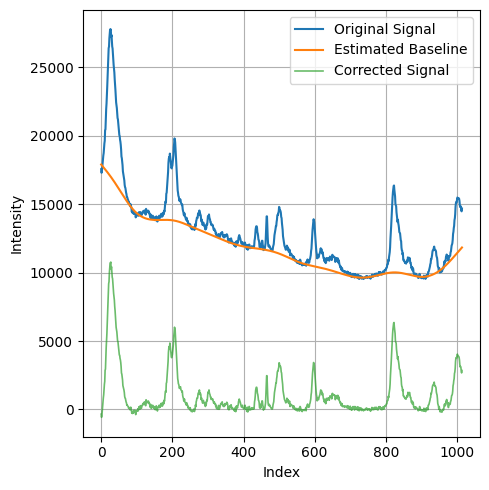

In [ ]:
def baseline_als_simple(y, lam=1e6, p=0.01, niter=10, show_plot=True, correct_negative=True):
    """
    Simple ALS baseline correction:
    - Standard asymmetric least squares without post-correction
    - lam --> smoothness parameter: controls the rigidity of the baseline. Higher the value, smoother the baseline. Range: 1e4 to 1e8
    - p --> asymmetry parameter: controls how much the baseline higs the data. Lower forces baseline to stay below peaks. Range: 0 to 1
    - niter --> number of ALS iterations: more iterations more accurate the baseline. Range: 1 to 100 (10 is usually enough)
    """
    from scipy import sparse
    from scipy.sparse.linalg import spsolve
    import numpy as np

    y = np.array(y)
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)

    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D @ D.T
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)

    corrected = y - z
    corrected_shifted = corrected.copy()
    shift_amount = 0

    if correct_negative:
        min_val = np.min(corrected)
        if min_val < 0:
            shift_amount = abs(min_val)
            corrected_shifted += shift_amount
            print(f"🔧 Shifted corrected signal by +{shift_amount:.4f} to remove negative values.")

 
    if show_plot:
        plt.figure(figsize=(5, 5))
        plt.plot(y, label="Original Signal", linewidth=1.5)
        plt.plot(z, label="Estimated Baseline", linewidth=1.5)
        plt.plot(corrected, label="Corrected Signal", linewidth=1.2, alpha=0.7)
        # if shift_amount > 0:
        #     plt.plot(corrected_shifted, label="Corrected (Shifted ≥ 0)", linewidth=1.2, linestyle='--', alpha=0.8)
        plt.legend()
        plt.xlabel("Index")
        plt.ylabel("Intensity")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return corrected_shifted if correct_negative else corrected, z

data = [list(map(float, line.split())) for line in open(r'Data\Renamed\6-1 copy\(6)-1_27__X_4.2__Y_0.3.txt')]
x, y = zip(*data)
corrected, baseline = baseline_als_simple(y, lam=1e5, p=0.01, niter=10, show_plot=True, correct_negative=True)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_simple(y, lam=1e6, p=0.01, niter=10):
    """
    Applies ALS baseline correction to a 1D signal `y`.
    Returns:
    - corrected: y - baseline
    - z: estimated baseline
    """
    y = np.array(y)
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)

    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D @ D.T
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)

    corrected = y - z
    return corrected, z

def plot_baseline_result(
    x, y, z, corrected,
    shift_if_negative=True,
    title="ALS Baseline Correction",
    save_path=None
):
    """
    Plots original signal, estimated baseline, and corrected signal.
    Optionally applies a shift to corrected signal for display only.
    """
    shift_amount = 0
    corrected_display = corrected
    if shift_if_negative and np.min(corrected) < 0:
        shift_amount = abs(np.min(corrected))
        corrected_display = corrected + shift_amount

    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label="Original Signal", linewidth=1.5)
    plt.plot(x, z, label="Estimated Baseline", linewidth=1.5)
    plt.plot(x, corrected, label="Corrected Signal (Raw)", linewidth=1.2, alpha=0.7)

    if shift_amount > 0:
        plt.plot(x, corrected_display, label=f"Corrected (Shifted +{shift_amount:.2f})", linestyle='--', linewidth=1.2, alpha=0.8)

    plt.title(title)
    plt.xlabel("Index or Wavenumber")
    plt.ylabel("Intensity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"🖼 Saved plot to: {save_path}")
        plt.close()
    else:
        plt.show()

def process_all_files(
    root_input='Data/Renamed',
    root_output='Data/ASL baseline corrected',
    folders=[f'{i}-{j}' for i in range(5, 10) for j in range(1, 3)],
    lam=1e5,
    p=0.005,
    niter=100
):
    """
    Processes all text files with ALS baseline correction and saves unshifted results.
    """
    for folder in folders:
        input_folder = os.path.join(root_input, f"{folder} copy")
        output_folder = os.path.join(root_output, folder)
        os.makedirs(output_folder, exist_ok=True)

        if not os.path.exists(input_folder):
            print(f"❌ Folder not found: {input_folder}")
            continue

        for filename in os.listdir(input_folder):
            if filename.endswith('.txt'):
                filepath = os.path.join(input_folder, filename)
                try:
                    data = [list(map(float, line.split())) for line in open(filepath)]
                    x, y = zip(*data)
                    corrected, _ = baseline_als_simple(
                        y, lam=lam, p=p, niter=niter
                    )

                    output_path = os.path.join(output_folder, filename)
                    np.savetxt(output_path, np.column_stack((x, corrected)), fmt='%.6f')
                    print(f"✅ Saved: {output_path}")
                except Exception as e:
                    print(f"⚠️ Error processing {filename}: {e}")
    print("✅ All files processed.")

def plot_corrected_file(
    filename,
    folder,
    root_input='Data/Renamed',
    root_output='Data/ASL baseline corrected',
    lam=1e5,
    p=0.005,
    niter=100
):
    """
    Plot a specific corrected file using original + baseline recomputation.
    """
    input_file = os.path.join(root_input, f"{folder} copy", filename)
    output_file = os.path.join(root_output, folder, filename)

    if not os.path.exists(input_file):
        print(f"❌ Input file not found: {input_file}")
        return
    if not os.path.exists(output_file):
        print(f"❌ Corrected file not found: {output_file}")
        return

    data_raw = [list(map(float, line.split())) for line in open(input_file)]
    x, y = zip(*data_raw)

    corrected, baseline = baseline_als_simple(y, lam=lam, p=p, niter=niter)

    plot_baseline_result(
        x, y, baseline, corrected,
        title=f"{filename} in {folder}",
        shift_if_negative=True
    )

# First run all processing
process_all_files()


✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_0__X_4.2__Y_35.4.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_100__X_8.1__Y_22.4.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_101__X_8.1__Y_21.1.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_102__X_8.1__Y_19.8.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_103__X_8.1__Y_18.5.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_104__X_8.1__Y_17.2.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_105__X_8.1__Y_15.9.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_106__X_8.1__Y_14.6.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_107__X_8.1__Y_13.3.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_108__X_8.1__Y_12.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_109__X_8.1__Y_10.7.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_10__X_4.2__Y_22.4.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_110__X_8.1__Y_9.4.txt
✅ Saved: Data/ASL baseline corrected\5-1\(5)-1_111__X_8.1__Y_8.1.txt
✅ Saved: Data/ASL baseline 

## After preprocessing: Visualize the results of preprocessing

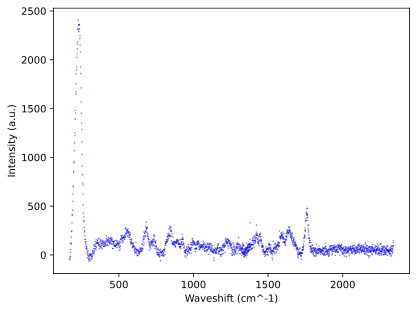

In [11]:
# Plotting the data from the file
data = [list(map(float, line.split())) for line in open(r'Data\ASL baseline corrected merged\8\(8)-_10__X_4.2__Y_22.4.txt')]
x, y = zip(*data)

plt.scatter(x, y, facecolors='none', edgecolors='blue', s=0.1, marker='o')
plt.xlabel('Waveshift (cm^-1)')
plt.ylabel('Intensity (a.u.)')
plt.show()

## Z-score normalization

In [1]:
import os
import numpy as np

def z_score_normalize(arr):
    return (arr - arr.mean()) / (arr.std() + 1e-8)

def normalize_and_save(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for folder in os.listdir(input_dir):
        input_folder_path = os.path.join(input_dir, folder)
        output_folder_path = os.path.join(output_dir, folder)

        if not os.path.isdir(input_folder_path):
            continue

        os.makedirs(output_folder_path, exist_ok=True)

        for fname in os.listdir(input_folder_path):
            if fname.endswith('.txt'):
                fpath = os.path.join(input_folder_path, fname)
                data = np.loadtxt(fpath)
                
                x_vals = data[:, 0]
                y_vals = data[:, 1]
                y_vals = z_score_normalize(y_vals)

                norm_data = np.column_stack((x_vals, y_vals))
                out_path = os.path.join(output_folder_path, fname)
                np.savetxt(out_path, norm_data)

if __name__ == "__main__":
    input_directory = "Data/ASL baseline corrected merged"
    output_directory = "Data/ALS baseline corrected normalized merged"
    normalize_and_save(input_directory, output_directory)

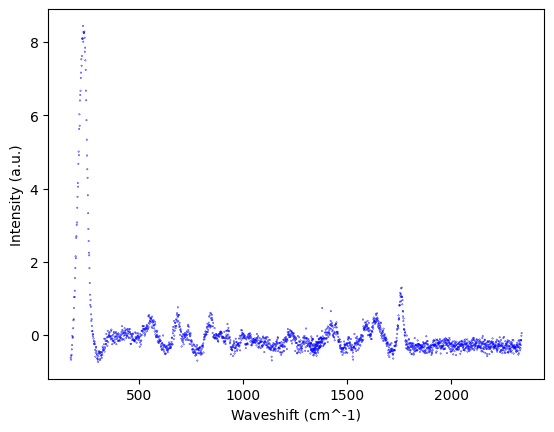

In [4]:
# Plotting the data from the file
data = [list(map(float, line.split())) for line in open(r'Data\ALS baseline corrected normalized merged\8\(8)-_10__X_4.2__Y_22.4.txt')]
x, y = zip(*data)

plt.scatter(x, y, facecolors='none', edgecolors='blue', s=0.1, marker='o')
plt.xlabel('Waveshift (cm^-1)')
plt.ylabel('Intensity (a.u.)')
plt.show()